In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import pickle 
from ply import write_ply

from utilities import *
from VoxelGrid import *
import os

from PIL import ImageFont
from PIL import ImageDraw 

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device='cuda' if torch.cuda.is_available() else 'cpu'

N_points=200
dataset= "../nerf_synthetic/mic"

In [2]:
focal, all_c2w, all_gt = get_data(dataset)

LOAD DATA ../nerf_synthetic/mic/train


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 61.19it/s]


In [3]:
red = 8
target_ims, rays = reduce_data(all_c2w, all_gt, focal, red)
im_w = target_ims[0].shape[0]
print(im_w)

red = 2
disp_ims, disp_rays = reduce_data(all_c2w, all_gt, focal, red)
disp_im_w = disp_ims[0].shape[0]
print(disp_im_w)

100
400


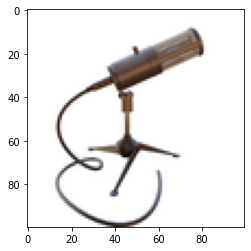

In [6]:
plt.imshow(target_ims[1])
plt.show()

In [5]:
test_focal, test_c2w, test_gt = get_data(dataset, "test")

LOAD DATA ../nerf_synthetic/drums/test


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 49.48it/s]


In [6]:
red = 8
disp_ims_test, disp_rays_test = reduce_data(test_c2w, test_gt,test_focal, red)
disp_im_w = disp_ims_test[0].shape[0]

# Train

In [4]:
D = RayDataset(target_ims, rays, device)
train_loader = torch.utils.data.DataLoader(D, batch_size=5000, shuffle=True)

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 25.84it/s]


In [5]:
def train(epoch, opt_color, N_points):
    losses=[]
    for batch_idx, (rays, pixels) in enumerate(train_loader):
        rays, pixels = (rays[0].to(device),rays[1].to(device)), pixels.to(device)
        opt_color.zero_grad()
        
        pix_estims = VG.render_rays(rays, (N_points))
        loss = ((pix_estims-pixels)**2).sum()/rays[0].shape[0]
            
        #loss = ((pix_estims-pixels)**2).sum()/rays[0].shape[0] +0.0001*VG.total_variation()
        #+ 0.1*opacity_loss(VG.opacities)
        
        loss.backward()
        losses.append(loss.item())
        #VG.update_grads(1000)
        opt_color.step()
        VG.clamp()
        

        if batch_idx%10==0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format( epoch,batch_idx,len(train_loader),100.0 * batch_idx / len(train_loader),loss.data.item(),))
    return losses

In [6]:
VG = VoxelGridSpherical(4)
VG.load('mic_carve.obj')

In [7]:
losses=[]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

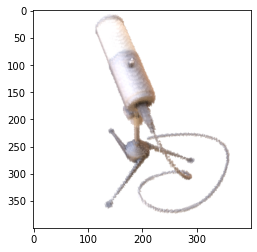

Train Epoch: 0 [0/200 (0%)]	Loss: 0.062103
Train Epoch: 0 [10/200 (5%)]	Loss: 0.063006
Train Epoch: 0 [20/200 (10%)]	Loss: 0.057769
Train Epoch: 0 [30/200 (15%)]	Loss: 0.057935
Train Epoch: 0 [40/200 (20%)]	Loss: 0.062196
Train Epoch: 0 [50/200 (25%)]	Loss: 0.061438
Train Epoch: 0 [60/200 (30%)]	Loss: 0.062093
Train Epoch: 0 [70/200 (35%)]	Loss: 0.057289
Train Epoch: 0 [80/200 (40%)]	Loss: 0.056125
Train Epoch: 0 [90/200 (45%)]	Loss: 0.051227
Train Epoch: 0 [100/200 (50%)]	Loss: 0.054562
Train Epoch: 0 [110/200 (55%)]	Loss: 0.059612
Train Epoch: 0 [120/200 (60%)]	Loss: 0.052957
Train Epoch: 0 [130/200 (65%)]	Loss: 0.055910
Train Epoch: 0 [140/200 (70%)]	Loss: 0.057324
Train Epoch: 0 [150/200 (75%)]	Loss: 0.051652
Train Epoch: 0 [160/200 (80%)]	Loss: 0.056175
Train Epoch: 0 [170/200 (85%)]	Loss: 0.054189
Train Epoch: 0 [180/200 (90%)]	Loss: 0.052335
Train Epoch: 0 [190/200 (95%)]	Loss: 0.053642


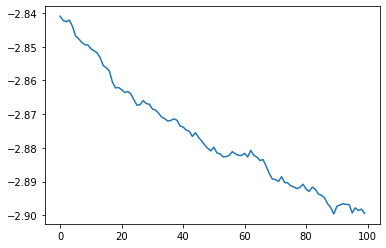

 25%|███████████▎                                 | 1/4 [01:27<04:22, 87.45s/it]

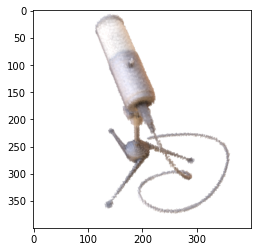

Train Epoch: 1 [0/200 (0%)]	Loss: 0.052357
Train Epoch: 1 [10/200 (5%)]	Loss: 0.045372


 25%|███████████▎                                 | 1/4 [01:37<04:53, 97.80s/it]


KeyboardInterrupt: 

In [8]:
epochss = [2, 4, 8, 8]
N_pointss = [2**(i+4) for i in range(4)]
lrs = [1000/2**i for i in range(4)]
lrs2 = [30 for i in range(4)]

epochss = [4]
N_pointss = [64]
lrs = [1000]



for epochs, N_points, lr in zip(epochss,N_pointss, lrs):
    #VG.subdivide()
    opt_c= torch.optim.SGD(
                [VG.colors], 
                lr=lr/10
            )
    opt_o= torch.optim.SGD(
                [VG.opacities], 
                lr=lr
            )
   
    for epoch in tqdm(range(epochs)):
        #VG.save("some.obj")
        plt.imshow(VG.render_large_image_from_rays(disp_rays[0],(500,1.2)))
        plt.show()
        losses += train(epoch, opt_c, N_points)
        plt.plot(np.log(rolling_average(np.array(losses))))
        plt.show()


    

In [282]:
compute_psnr(VG, disp_rays_test, disp_ims_test, N_points=1000)


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 39.88it/s]


20.120240796680978

# View images

In [8]:
VG = VoxelGrid()

model = "drums"
VG.load(model+'.obj')



In [9]:
dataset= "../nerf_synthetic/"+model
test_focal, test_c2w, test_gt = get_data(dataset, "test")
red = 4
disp_ims_test, disp_rays_test = reduce_data(test_c2w, test_gt,test_focal, red)


LOAD DATA ../nerf_synthetic/drums/test


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 47.31it/s]


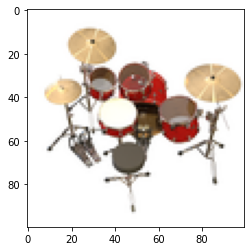

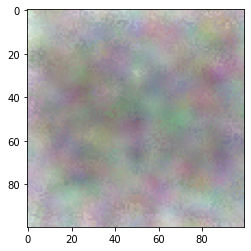

In [70]:
image_ind=0


plt.imshow(disp_ims_test[image_ind])
plt.show()

new_im = VG.render_large_image_from_rays(disp_rays_test[image_ind],(32,1.2))

plt.imshow(new_im)
plt.show()

# ROTATION

In [5]:
cust_c2ws = create_rotation_matrices(1.5,-20, n=60)
red_fac=2
ordir_rays=[]
for c2w in cust_c2ws:
    ray_np = get_rays_np(800,800, focal, c2w)
    oris = ray_np[0][::red_fac,::red_fac]
    direct = ray_np[1][::red_fac,::red_fac] # direction. optimal fac:3
    ordir_rays.append((oris, direct))

In [7]:
VG=VoxelGrid()
VG.load('lego.obj')

In [19]:
VG.subdivide()

In [13]:
VG.treshold_opacity(0.5)

  0%|                                                    | 0/60 [00:00<?, ?it/s]

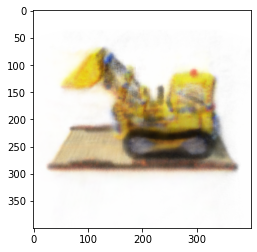

  0%|                                                    | 0/60 [00:00<?, ?it/s]


In [8]:
imgs=[]
for image_ind in tqdm(range(len(cust_c2ws))):
    with torch.no_grad():
        new_im = VG.render_large_image_from_rays(ordir_rays[image_ind],(500, 1.2))
        plt.imshow(new_im)
        plt.show()
        break
        #imgs.append(np.uint8(255*new_im))

In [23]:
imageio.mimwrite('screenshots/ficus_best2.gif', imgs,  format='GIF', duration=0.04)

In [144]:
VG.save_pointcloud()

In [11]:
rays_or_dir = [get_rays_np(800,800, focal, c2w) for c2w in all_c2w]

In [12]:
camera_centers = get_cameras_centers(rays_or_dir)

[3.8 0.  1. ]


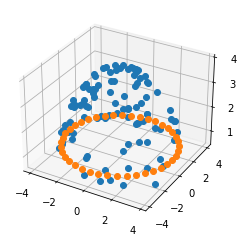

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot( camera_centers[:,0], camera_centers[:, 1], camera_centers[:,2], 'o')

n = 40
t = np.linspace(0,2*np.pi, n+1)[:-1]
cust_centers = np.zeros((n,3))
cust_centers[:,0] = np.cos(t)*3.8
cust_centers[:,1] = np.sin(t)*3.8
cust_centers[:,2] = 1

cust_c2ws = [create_rotation_transformation_matrix(cust_centers[i], t[i], -np.pi*0.1) for i in range(n)]

ax.plot( cust_centers[:,0], cust_centers[:,1], cust_centers[:,2], 'o')

print(cust_centers[0])



In [12]:
L=[]
k=0
i=0
while i<39:
    k+=1
    for _ in range(4):
        L.append(i)
        i+=k
L

[0, 1, 2, 3, 4, 6, 8, 10, 12, 15, 18, 21, 24, 28, 32, 36]

In [64]:
L = range(15)

In [12]:

images=[]
for ind in tqdm([0,1,3,7,15,40]):
    VG.load('16a_'+str(ind)+'.obj')
    for image_ind in (range(len(cust_c2ws))):
        new_im = VG.render_large_image_from_rays(ordir_rays[image_ind], (500, 1.2))
        img = Image.fromarray(np.uint8(255*np.clip(new_im,0,1)))
        draw = ImageDraw.Draw(img)
        draw.text((10, 10),"Epoch:"+str(ind),(0,0,0))
        images.append(np.array(img))
        #plt.imshow(images[-1])
        #plt.show()
        #images.append(np.uint8(255*new_im))
        #plt.imsave('screenshots/rotate/'+str(ind)+'_'+str(image_ind)+'.png', new_im)


100%|█████████████████████████████████████████████| 6/6 [02:43<00:00, 27.19s/it]


In [36]:
images2=[]
k=0
while k<len(images):
    for _ in range(30):
        images2.append(images[k])
        k+=1
    k+=60

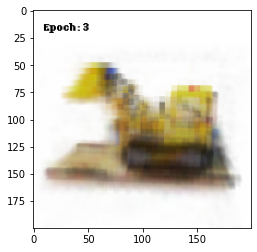

In [45]:
plt.imshow(images2[61])

In [14]:
imageio.mimwrite('exports/movies_training_full.gif', images,  format='GIF', duration=0.04)

# INTERP

In [26]:
offsets = np.array([[0,0,0], #base
                           [0,0,0], 
                           [1,0,0], 
                           [0,0,1],
                           [1,0,1],
                           [0,1,0],
                           [1,1,0],  
                           [0,1,1],
                           [1,1,1]])


In [57]:

class VoxelGridInterp(VoxelGrid):
    def in_bounds_indices(self, p):
        ''' input: Nx3 array
            output: index of valid arrays'''
        in_x = (p[...,0]>=0)*(p[...,0]<(self.size-1))
        in_y = (p[...,1]>=0)*(p[...,1]<(self.size-1))
        in_z = (p[...,2]>=0)*(p[...,2]<(self.size-1))
        return in_x*in_y*in_z
   
    def render_rays(self, ordir_tuple, N_points, inv_depth=1.2):
        with torch.no_grad():
            ori = ordir_tuple[0][:, None,:]
            # WARNING: Assuming constant distance
            distances = 10*torch.sqrt( (ordir_tuple[1]**2).sum(1, keepdim=True))/inv_depth/(N_points-1)
            scatter_points = torch.rand_like(distances)*distances + torch.linspace(0,10, N_points, device=device)[None, :]/inv_depth
            p = ori + scatter_points[:,:,None]*(ordir_tuple[1][:, None, :])

            offsets = torch.tensor([[0,0,0], 
                               [1,0,0], 
                               [0,0,1],
                               [1,0,1],
                               [0,1,0],
                               [1,1,0],  
                               [0,1,1],
                               [1,1,1]], device=device)
            offsets[:, 1] *= self.size
            offsets[:, 2] *= self.size**2
            offsets = offsets.sum(1)

        
            #indicies
            p = self.descartes_to_indices(p)   
            p0 = torch.floor(p)
            in_bounds = self.in_bounds_indices(p)

            mesh_coords = self.flatten_3d_indices(p0.long())
            mesh_coords[torch.logical_not(in_bounds)] = 0

            diff = (p-p0)
            ind_offsets = []

            mcs = []
            for i in range(8):
                mcs.append( mesh_coords + offsets[i])                
        # color interp
        ciii = [self.colors[mcs[i]]
                *(1-diff[...,0, None])+
                self.colors[mcs[i+1]]
                *diff[...,0, None] for i in range(0,8,2)]
        cii = [ciii[i]*(1-diff[...,1, None]) + ciii[i+2]*diff[...,1, None] for i in [0,1]]
        colors = cii[0]*(1-diff[...,2, None])+cii[1]*diff[...,2, None]
        
        # opacities interp
        oiii = [self.opacities[mcs[i]]
               *(1-diff[...,0]) +
                self.opacities[mcs[i+1]]
                *diff[...,0] for i in range(0,8,2)]
        oii = [oiii[i]*(1-diff[...,1]) + oiii[i+2]*diff[...,1] for i in [0,1]]
        opacities = (oii[0]*(1-diff[...,2])+oii[1]*diff[...,2])*distances*in_bounds.float() 

        cumsum_opacities = torch.cumsum(opacities, 1)

        transp_term = torch.exp(-cumsum_opacities)*(1-torch.exp(-opacities))
        return (colors*transp_term[..., None]).sum(1) + torch.exp(-cumsum_opacities[:, -1])[..., None]
    



In [48]:
VG = VoxelGrid(32,1)



In [49]:
with torch.no_grad():
    VG.opacities[:] = 2
    VG.colors[:] = 0
    VG.colors[:, 1] = 0.5
    for i in range(VG.size):
        for j in range(0, VG.size,2):
            for k in range(VG.size):
    
                VG.colors[i+VG.size*j+VG.size**2*k, 1] = 0
                VG.colors[i+VG.size*j+VG.size**2*k, 2] = 0.5
       
     


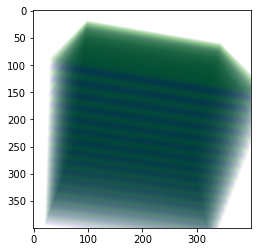

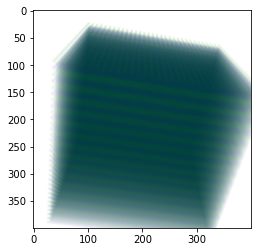

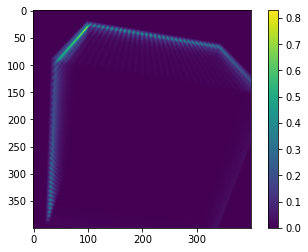

In [50]:
from time import time

#VG= VoxelGridInterp(16,1.4)

im1=VG.render_large_image_from_rays(disp_rays[10],(1000,1.2))
VG.subdivide()
im2=VG.render_large_image_from_rays(disp_rays[10],(1000,1.2))
plt.imshow(im1)
plt.show()
plt.imshow(im2)
plt.show()


plt.imshow(((im1-im2)**2).sum(2))
plt.colorbar()
plt.show()
#VG.alive